# Latihan

## Dengan menggunakan data konsumsi energi tiap rumah di atas, buatlah model neural network untuk memprediksi kolom listrik berdasarkan input kolom luas_bangunan dengan ketentuan sebagai berikut!

1. Arsitektur neural network terdiri dari:
- Input layer, hidden layer (Dense layer, Dropout, Dense layer), Dense ouput layer
- Fungsi aktivasi yang digunakan pada kedua Dense layer adalah 'ReLu'
- Persentase Dropout yang digunakan 10%
- Compiler: loss='mse', optimizer='adam', metrics=['mae']

2. Model dibuat menggunakan GridSearchCV dengan paramater yang diuji:
- banyaknya neuron pada Dense layer pertama = [16,32,64]
- banyaknya neuron pada Dense layer kedua = [10,20,30]

3. Early Stopping diterapkan sehingga training berhenti pada saat epoch yang optimal

4. Lakukan evaluasi pada data test dan simpulkan hasil evaluasi tersebut

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
file_ = 'data/konsumsi_energi.csv'
try: # Running Locally
    energi = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/ptpjb/main/{file_}
    energi = pd.read_csv(file_)
energi.head(10)

,jumlah_ruangan,jumlah_penghuni,luas_bangunan,listrik
0,2,1,49.8,24.0
1,7,2,91.4,21.6
2,7,2,40.3,34.7
3,2,3,29.4,33.4
4,2,3,53.3,36.2
5,2,3,52.1,28.7
6,7,5,124.3,22.9
7,7,5,191.5,27.1
8,7,5,299.3,16.5
9,7,5,171.0,18.9


# Preprocessing
1. EDA
2. Menentukan variabel target dan input
3. Split Data
4. Feature Scalling

In [3]:
# Membuang kolom jumlah_ruangan dan jumlah_penghuni
energi = energi.drop(columns=['jumlah_ruangan','jumlah_penghuni'])
energi.head()

,luas_bangunan,listrik
0,49.8,24.0
1,91.4,21.6
2,40.3,34.7
3,29.4,33.4
4,53.3,36.2


,luas_bangunan,listrik
count,504.000000,504.000000
mean,126.859325,22.474008
std,71.355341,9.132927
min,17.300000,5.000000
25%,70.925000,16.950000
50%,113.950000,21.200000
75%,169.925000,25.000000
max,379.700000,50.000000


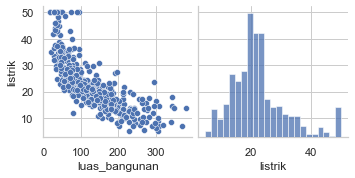

In [4]:
# Melihat visualisasi dan statistika deskriptif data

sns.pairplot(energi, y_vars='listrik')
energi.describe()

In [5]:
# Menentukan variabel target dan input
y = energi[['listrik']].values
X = energi[['luas_bangunan']].values

# Check the shape of training data
print(X.shape,y.shape)
print(type(y),type(X))

(504, 1) (504, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [6]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('Banyak data train:', len(X_train))
print('Banyak data test :', len(X_test))

Banyak data train: 403
Banyak data test : 101


In [7]:
# feature scalling
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(X_train)
scaler2 = MinMaxScaler()
scaler2.fit(y_train)

X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)
y_train_scaled = scaler2.transform(y_train)
y_test_scaled = scaler2.transform(y_test)

# Membuat Model
1. Membuat fungsi model neural network
2. Membuat model dengan KerasRegressor
3. Menentukan parameter-paramater untuk melakukan grid search
4. Membuat model dengan GridSearchCV
5. Melakukan Training
6. Memilih model neural network terbaik
7. Mengevaluasi model

In [8]:
# Membuat fungsi model neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_model(neurons_1=16, neurons_2=10):
    # create model
    model = Sequential()
    model.add(Dense(neurons_1, input_dim=1, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [9]:
# Cek summary model default
model = create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Membuat model dengan KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

# Early Stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=500, validation_split=0.1, batch_size=32, callbacks=[es], verbose=0)

In [11]:
# Menentukan parameter-paramater untuk melakukan grid search

neurons_1 = [16, 32, 64]
neurons_2 = [10, 20, 30]
param_grid = dict(neurons_1=neurons_1, neurons_2=neurons_2)

In [12]:
# Membuat model dengan GridSearchCV

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [13]:
# Training model
grid_result = grid.fit(X_train_scaled, y_train_scaled)

In [14]:
# Memilih model terbaik

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_model = grid_result.best_estimator_.model
history = best_model.history

Best: -0.015568 using {'neurons_1': 16, 'neurons_2': 20}


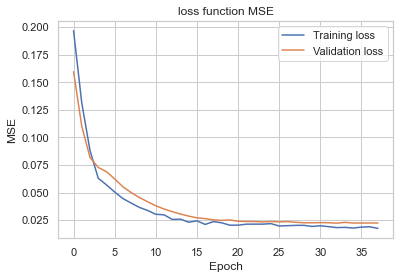

In [15]:
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

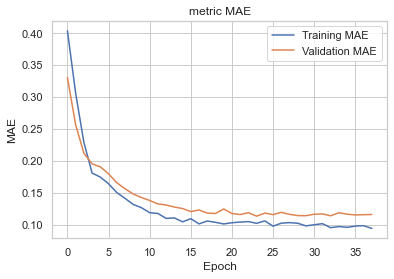

In [16]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

MAE data test sebesar: 4.146952279723517


<AxesSubplot:>

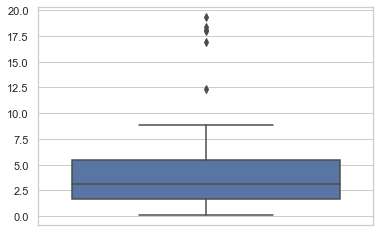

In [17]:
# Evaluasi model dengan data test

y_pred = best_model.predict(X_test_scaled)
y_pred = scaler2.inverse_transform(y_pred)

abs_error = np.abs(y_test-y_pred)

# Mean Absolute Error (MAE) test data
mae = np.mean(abs_error)
print('MAE data test sebesar:', mae)

sns.boxplot(y = abs_error)

<AxesSubplot:xlabel='luas_bangunan', ylabel='listrik'>

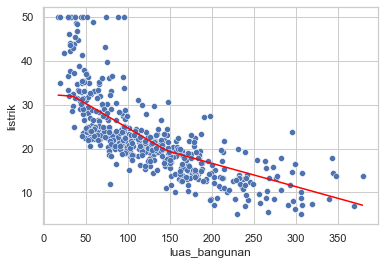

In [18]:
# plot data observasi dan hasil prediksi

sns.scatterplot(data=energi,x='luas_bangunan',y='listrik')

prediksi = best_model.predict(scaler1.transform(X))
prediksi = scaler2.inverse_transform(prediksi)
energi['prediksi'] = prediksi

sns.lineplot(data=energi,x='luas_bangunan',y='prediksi', color="red")